In [1]:
import os
from zipfile import ZipFile
import numpy as np
import xarray as xr


In [2]:
def unzip_all_folders(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.zip'):
                zip_file_path = os.path.join(root, file)
                extract_path = os.path.join(root, file[:-4])  # Create a folder with the same name as the zip file
                with ZipFile(zip_file_path, 'r') as zip_ref:
                    zip_ref.extractall(extract_path)
                    print(f"Extracted '{file}' to '{extract_path}'")

In [3]:
unzip_all_folders('./Agera5')


Extracted '6835ae41e98ac4f33b35b50f7dd99bcd.zip' to './Agera5/6835ae41e98ac4f33b35b50f7dd99bcd'
Extracted 'cb5f53868a319d428e3a2e093df8eb95.zip' to './Agera5/cb5f53868a319d428e3a2e093df8eb95'
Extracted '775d57cb0c5b056322cd4f98c61f3f48.zip' to './Agera5/775d57cb0c5b056322cd4f98c61f3f48'
Extracted '5eff1f559bae241615f4d77cd2573fb4.zip' to './Agera5/5eff1f559bae241615f4d77cd2573fb4'
Extracted 'ef52d6ee2b67d320361f74c0166c7637.zip' to './Agera5/ef52d6ee2b67d320361f74c0166c7637'
Extracted '9c6654a9b6d771b40f7f505913834d6f.zip' to './Agera5/9c6654a9b6d771b40f7f505913834d6f'
Extracted 'faffc5f2a2b0d63d468827e3afb37040.zip' to './Agera5/faffc5f2a2b0d63d468827e3afb37040'
Extracted 'f893a90eee134ea8a8f9fb8b87bccc45.zip' to './Agera5/f893a90eee134ea8a8f9fb8b87bccc45'
Extracted 'ba2aa74fec6a7c602a8971f39368ac71.zip' to './Agera5/ba2aa74fec6a7c602a8971f39368ac71'
Extracted '7581d0e4b4b4a3e747499ed7c3fe40f6.zip' to './Agera5/7581d0e4b4b4a3e747499ed7c3fe40f6'
Extracted '115cdb640d77a1298af3c601b3c67

In [4]:
main_folder_path = './Agera5'

netcdf_files = []
for dirpath, dirnames, filenames in os.walk(main_folder_path):
    for filename in filenames:
        if filename.endswith('.nc'):
            netcdf_files.append(os.path.join(dirpath, filename))

In [5]:
ds = xr.open_mfdataset(netcdf_files, combine='by_coords', parallel=True)


In [6]:
subset_dsagera5 = ds.sel(lat=slice(70, 30), lon=slice(-10, 45),time=slice('2012-01-01', '2023-12-31'))

In [7]:
eobsv30=xr.open_dataset('EOBS-RR/rr_ens_mean_0.1deg_reg_v30.0e.nc')

In [8]:
mars25=xr.open_dataset('MARS_JRC_25/MARS_METEO_DB_v2024.02_corr.nc')


In [9]:
selected_data_eobsv30 = eobsv30.sel(latitude=slice(30, 70), longitude=slice(-10, 45), time=slice('2012-01-01', '2023-12-31'))


In [10]:
selected_data_mars25 = mars25.sel(lat=slice(30, 70), lon=slice(-10, 45), time=slice('2012-01-01', '2023-12-31'))
selected_data_mars25 = selected_data_mars25.rename({'lat': 'latitude', 'lon': 'longitude'})

In [11]:
lat = np.where(subset_dsagera5.lat.values > 90, subset_dsagera5.lat.values - 90, subset_dsagera5.lat.values)
dsager = subset_dsagera5.assign_coords(lat=(["lat"], lat))
da = dsager.sortby('lat')
ds_reordered = da.transpose('time','lat', 'lon')


In [12]:
print(selected_data_eobsv30.rr.dims)
print(selected_data_mars25.Rain.dims)
print(ds_reordered.Precipitation_Flux.dims)

('time', 'latitude', 'longitude')
('time', 'latitude', 'longitude')
('time', 'lat', 'lon')


In [13]:
print(selected_data_eobsv30.rr.size)
print(selected_data_mars25.Rain.size)
print(ds_reordered.Precipitation_Flux.size)

964260000
94996692
964260000


In [14]:
subset_dsagera5_aligned_eobsv30 = ds_reordered.Precipitation_Flux.sel(
    lat=selected_data_eobsv30.latitude,
    lon=selected_data_eobsv30.longitude,
    time=selected_data_eobsv30.time,
    method='nearest'
)


subset_dsagera5_aligned_mars25 = ds_reordered.Precipitation_Flux.sel(
    lat=selected_data_mars25.latitude,
    lon=selected_data_mars25.longitude,
    time=selected_data_mars25.time,
    method='nearest'
)



In [15]:
print('Resolution EOBSv30 v AgERA5:',subset_dsagera5_aligned_eobsv30.rio.resolution(),selected_data_eobsv30.rio.resolution())


Resolution EOBSv30 v AgERA5: (0.09999999959995305, 0.09999999557312493) (0.09999999959995305, 0.09999999557312493)


In [16]:
print('Resolution MARS_25 v AgERA5:',subset_dsagera5_aligned_mars25.rio.resolution(),selected_data_mars25.rio.resolution())



Resolution MARS_25 v AgERA5: (0.317621, 0.317621) (0.317621, 0.317621)


In [17]:
bias_eobsv30 = selected_data_eobsv30.rr - subset_dsagera5_aligned_eobsv30


bias_mars25 = selected_data_mars25.Rain - subset_dsagera5_aligned_mars25


In [18]:
mean_bias_eobsv30 = bias_eobsv30.mean(dim=('latitude', 'longitude'))

mean_bias_mars25 = bias_mars25.mean(dim=('latitude', 'longitude'))


In [19]:
corr_bias_agera_vs_eobsv30=subset_dsagera5_aligned_eobsv30+mean_bias_eobsv30

corr_bias_agera_vs_mars25=subset_dsagera5_aligned_mars25+mean_bias_mars25


In [20]:
monthly_ref_eobsv30 = selected_data_eobsv30['rr'].resample(time='M',skipna=True).mean()
monthly_ref_mars25 = selected_data_mars25['Rain'].resample(time='M',skipna=True).mean()

monthly_row_agera5 = ds_reordered['Precipitation_Flux'].resample(time='M',skipna=True).mean()

monthly_bias_eobsv30 = corr_bias_agera_vs_eobsv30.resample(time='M',skipna=True).mean()
monthly_bias_mars25 = corr_bias_agera_vs_mars25.resample(time='M',skipna=True).mean()

In [21]:
monthly_ref_mean_eobsv30 = monthly_ref_eobsv30.mean(dim=('longitude', 'latitude'))
monthly_row_mean_agera5 = monthly_row_agera5.mean(dim=('lon', 'lat'))
monthly_bias_mean_eobsv30 = monthly_bias_eobsv30 .mean(dim=('longitude', 'latitude'))

In [22]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt


Text(0.5, 1.0, 'Monthly time series of Precipitations @ EU EOBS_v30 v AgERA5_v1 v AgERA5_v1-BIAS')

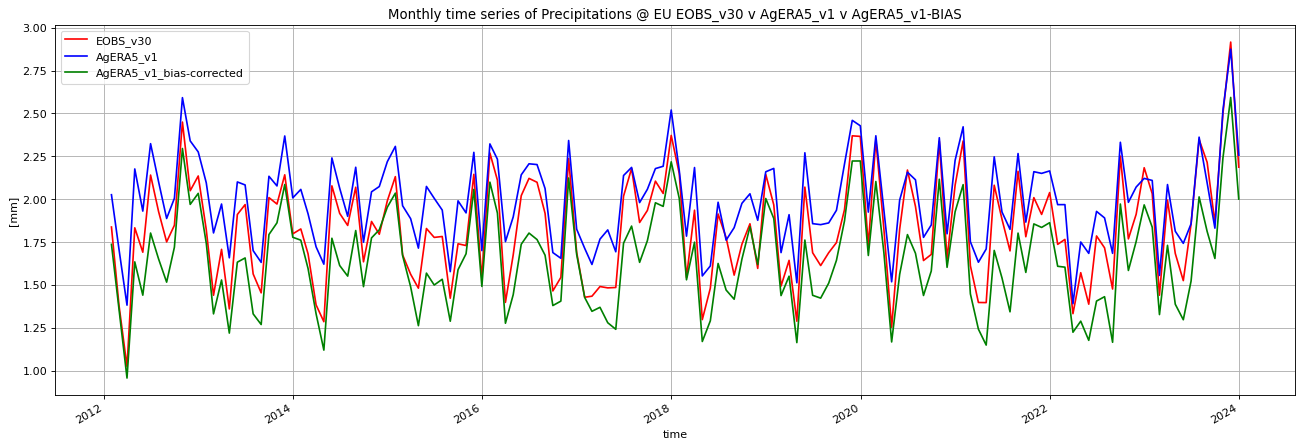

In [23]:
figure(figsize=(20, 6), dpi=80)
monthly_ref_mean_eobsv30.plot(color='r') #eobs
monthly_row_mean_agera5.plot(color='b') #agera
monthly_bias_mean_eobsv30.plot(color='g') #ageraBias
plt.ylabel('[mm]')
plt.grid()
plt.legend (['EOBS_v30', 'AgERA5_v1','AgERA5_v1_bias-corrected'],loc = 'upper left')
plt.title('Monthly time series of Precipitations @ EU EOBS_v30 v AgERA5_v1 v AgERA5_v1-BIAS',fontsize= '12')

In [24]:
monthly_ref_mean_mars25 = monthly_ref_mars25.mean(dim=('longitude', 'latitude'))
monthly_row_mean_agera5 = monthly_row_agera5.mean(dim=('lon', 'lat'))
monthly_bias_mean_mars25 = monthly_bias_mars25 .mean(dim=('longitude', 'latitude'))

Text(0.5, 1.0, 'Monthly time series of Precipitations @ EU MARS25 v AgERA5_v1 v AgERA5_v1-BIAS')

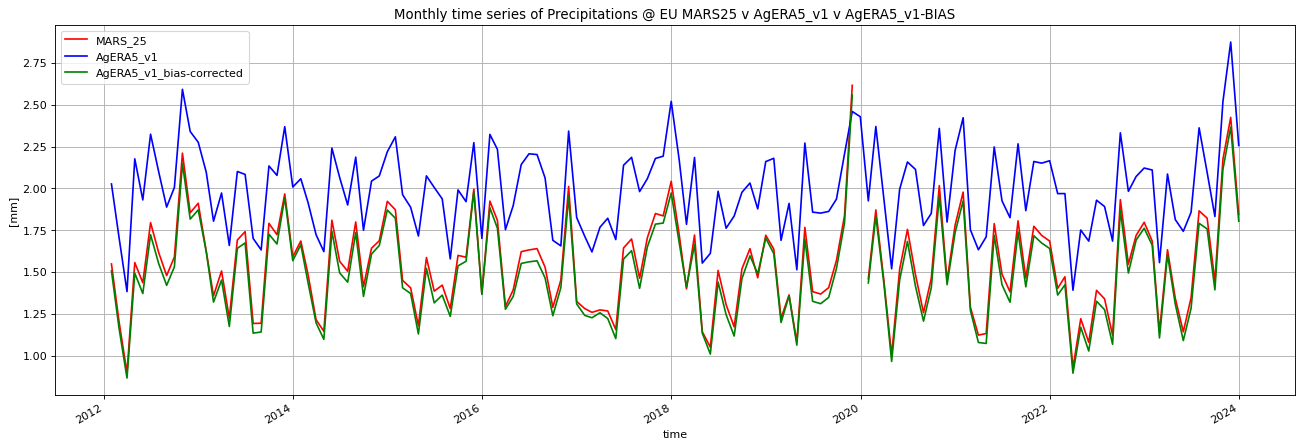

In [25]:
figure(figsize=(20, 6), dpi=80)
monthly_ref_mean_mars25.plot(color='r') #eobs
monthly_row_mean_agera5.plot(color='b') #agera
monthly_bias_mean_mars25.plot(color='g') #ageraBias
plt.ylabel('[mm]')
plt.grid()
plt.legend (['MARS_25', 'AgERA5_v1','AgERA5_v1_bias-corrected'],loc = 'upper left')
plt.title('Monthly time series of Precipitations @ EU MARS25 v AgERA5_v1 v AgERA5_v1-BIAS',fontsize= '12')

In [26]:
seasonal_ref_eobsv30 = selected_data_eobsv30['rr'].groupby(selected_data_eobsv30["time"].dt.month).mean()
seasonal_row_t = ds_reordered['Precipitation_Flux'].groupby(ds_reordered["time"].dt.month).mean()
seasonal_bias_eobsv30 = corr_bias_agera_vs_eobsv30.groupby(corr_bias_agera_vs_eobsv30["time"].dt.month).mean()

In [27]:
seasonal_ref_eobsv30 = seasonal_ref_eobsv30.mean(dim=('longitude', 'latitude'))
seasonal_row_mean_t = seasonal_row_t.mean(dim=('lon', 'lat'))
seasonal_bias_mean_eobsv30 = seasonal_bias_eobsv30.mean(dim=('longitude', 'latitude'))

Text(0.5, 1.0, 'Annual cycle of monthly Precipitations @ EU EOBS_v30 v AgERA5_v1 v AgERA5_v1-BIAS')

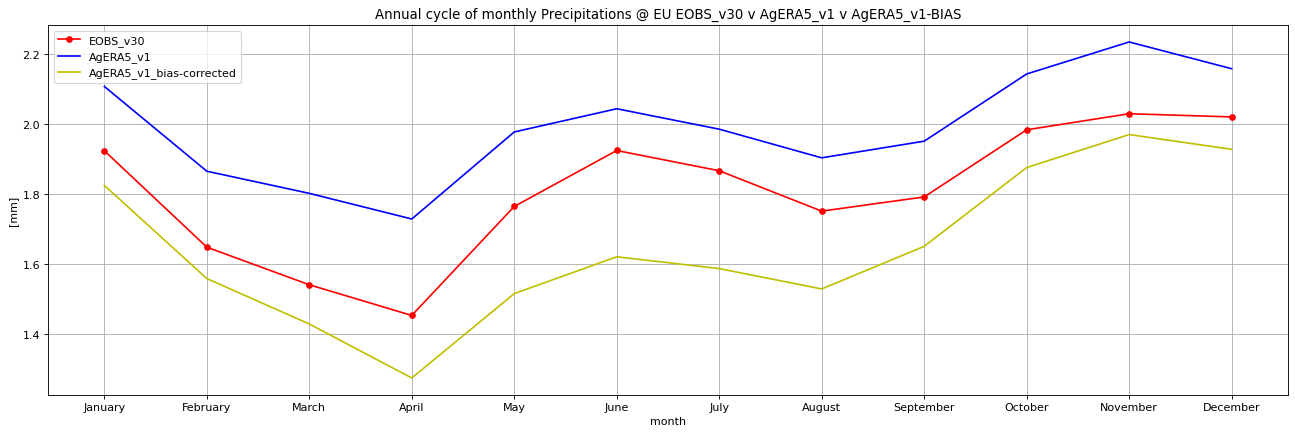

In [28]:
figure(figsize=(20, 6), dpi=80)
seasonal_ref_eobsv30.plot (color='r', marker=".", markersize=10)
seasonal_row_mean_t.plot(color='b')
seasonal_bias_mean_eobsv30.plot(color='y')
plt.xlabel('month')
plt.ylabel('[mm]')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],['January', 'February', 'March','April','May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.grid()
plt.legend (['EOBS_v30', 'AgERA5_v1','AgERA5_v1_bias-corrected'])
plt.title('Annual cycle of monthly Precipitations @ EU EOBS_v30 v AgERA5_v1 v AgERA5_v1-BIAS')

In [29]:
seasonal_ref_mars25 = selected_data_mars25['Rain'].groupby(selected_data_mars25["time"].dt.month).mean()
seasonal_row_t = ds_reordered['Precipitation_Flux'].groupby(ds_reordered["time"].dt.month).mean()
seasonal_bias_mars25 = corr_bias_agera_vs_mars25.groupby(corr_bias_agera_vs_mars25["time"].dt.month).mean()

In [30]:
seasonal_ref_mars25 = seasonal_ref_mars25.mean(dim=('longitude', 'latitude'))
seasonal_row_mean_t = seasonal_row_t.mean(dim=('lon', 'lat'))
seasonal_bias_mean_mars25 = seasonal_bias_mars25.mean(dim=('longitude', 'latitude'))

Text(0.5, 1.0, 'Annual cycle of monthly Precipitations @ EU MARS_25 v AgERA5_v1 v AgERA5_v1-BIAS')

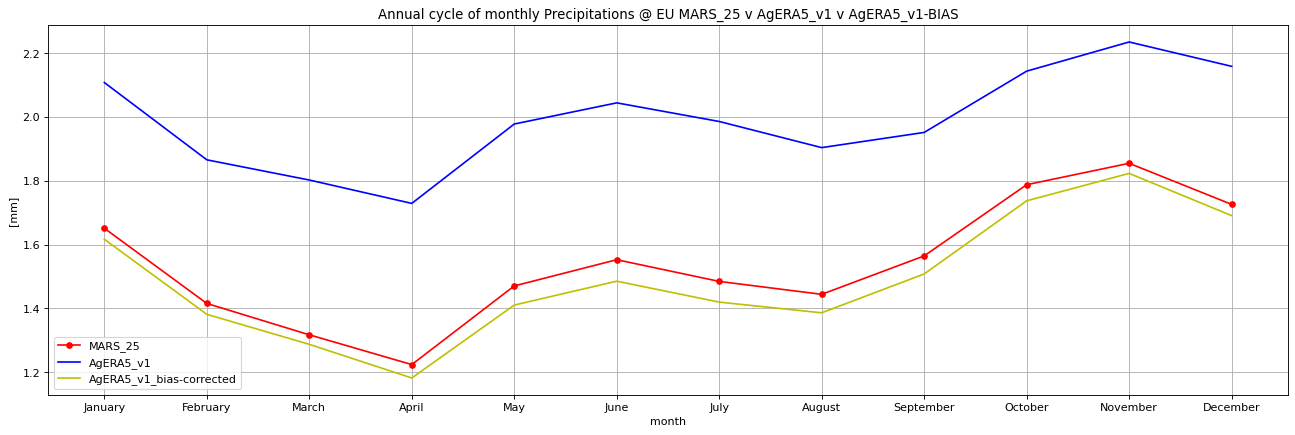

In [31]:
figure(figsize=(20, 6), dpi=80)
seasonal_ref_mars25.plot (color='r', marker=".", markersize=10)
seasonal_row_mean_t.plot(color='b')
seasonal_bias_mean_mars25.plot(color='y')
plt.xlabel('month')
plt.ylabel('[mm]')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12],['January', 'February', 'March','April','May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.grid()
plt.legend (['MARS_25', 'AgERA5_v1','AgERA5_v1_bias-corrected'])
plt.title('Annual cycle of monthly Precipitations @ EU MARS_25 v AgERA5_v1 v AgERA5_v1-BIAS')

In [32]:
mean_ref_eobsv30 =selected_data_eobsv30['rr'].resample(time='Y',skipna=True).mean()
mean_row_t =ds_reordered['Precipitation_Flux'].resample(time='Y',skipna=True).mean()
mean_bias_eobsv30 =corr_bias_agera_vs_eobsv30.resample(time='Y',skipna=True).mean()

mean_ref_eobsv30 = mean_ref_eobsv30.mean(dim='time')
mean_row_t = mean_row_t.mean(dim='time')
mean_bias_eobsv30 = mean_bias_eobsv30.mean(dim='time')

In [33]:
mean_ref_mars25 =selected_data_mars25['Rain'].resample(time='Y',skipna=True).mean()
mean_row_t =ds_reordered['Precipitation_Flux'].resample(time='Y',skipna=True).mean()
mean_bias_mars25 =corr_bias_agera_vs_mars25.resample(time='Y',skipna=True).mean()

mean_ref_mars25 = mean_ref_mars25.mean(dim='time')
mean_row_t = mean_row_t.mean(dim='time')
mean_bias_mars25 = mean_bias_mars25.mean(dim='time')

In [34]:
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.feature as cf

Text(0.5, 1.0, 'EOBS_v30 annual average total precipitation (2012-2023)')

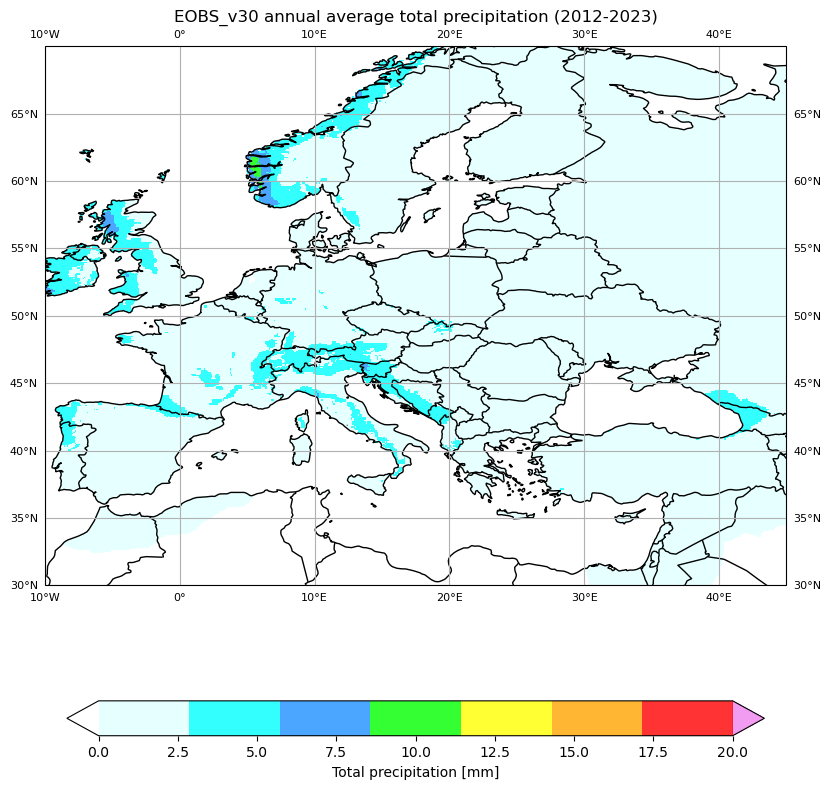

In [35]:
fig = plt.figure(figsize=(18, 10))
ax = plt.subplot(projection=ccrs.PlateCarree())
lons = mean_ref_eobsv30.longitude.values
lats = mean_ref_eobsv30.latitude.values
data = mean_ref_eobsv30.squeeze()
g1 = ax.gridlines(draw_labels = True)
g1.xlabel_style = {'size': 8, 'color': 'k'}
g1.ylabel_style = {'size': 8, 'color': 'k'}
cmap_prec = mpl.colors.ListedColormap(['lightcyan','cyan','dodgerblue','lime', 'yellow','orange','red']) 
cmap_prec.set_over('violet')
cmap_prec.set_under('white')
im=ax.pcolormesh(lons, lats , data, shading='auto',
              alpha=0.8, cmap=cmap_prec,antialiased=True, linewidth=0.5,vmin= 0, vmax=20)
cbar = fig.colorbar(im, extend='both', shrink=0.5, ax=ax,orientation= 'horizontal')#,ticklocation= 'bottom')
cbar.set_label('Total precipitation [mm]')
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)
#ax.set_xlim([2, 25])
#ax.set_ylim([32.5, 50.])
plt.title('EOBS_v30 annual average total precipitation (2012-2023)',fontsize= '12')

Text(0.5, 1.0, 'MARS_25 annual average total precipitation (2012-2023)')

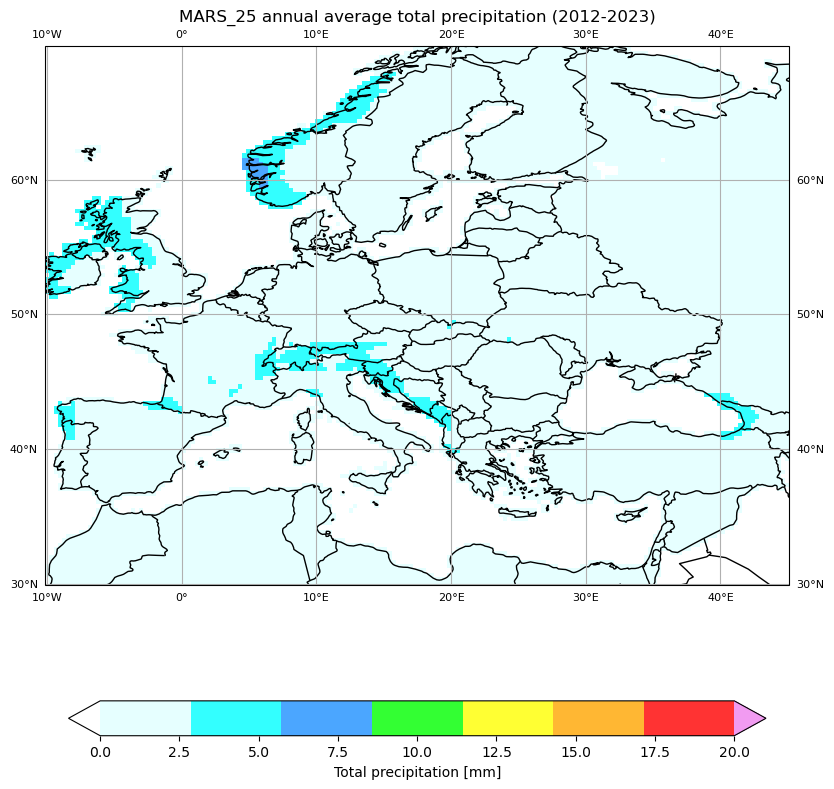

In [36]:
fig = plt.figure(figsize=(18, 10))
ax = plt.subplot(projection=ccrs.PlateCarree())
lons = mean_ref_mars25.longitude.values
lats = mean_ref_mars25.latitude.values
data = mean_ref_mars25.squeeze()
g1 = ax.gridlines(draw_labels = True)
g1.xlabel_style = {'size': 8, 'color': 'k'}
g1.ylabel_style = {'size': 8, 'color': 'k'}
cmap_prec = mpl.colors.ListedColormap(['lightcyan','cyan','dodgerblue','lime', 'yellow','orange','red']) 
cmap_prec.set_over('violet')
cmap_prec.set_under('white')
im=ax.pcolormesh(lons, lats , data, shading='auto',
              alpha=0.8, cmap=cmap_prec,antialiased=True, linewidth=0.5,vmin= 0, vmax=20)
cbar = fig.colorbar(im, extend='both', shrink=0.5, ax=ax,orientation= 'horizontal')#,ticklocation= 'bottom')
cbar.set_label('Total precipitation [mm]')
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)
#ax.set_xlim([2, 25])
#ax.set_ylim([32.5, 50.])
plt.title('MARS_25 annual average total precipitation (2012-2023)',fontsize= '12')

Text(0.5, 1.0, 'AgERA5 annual average total precipitation (2012-2023)')

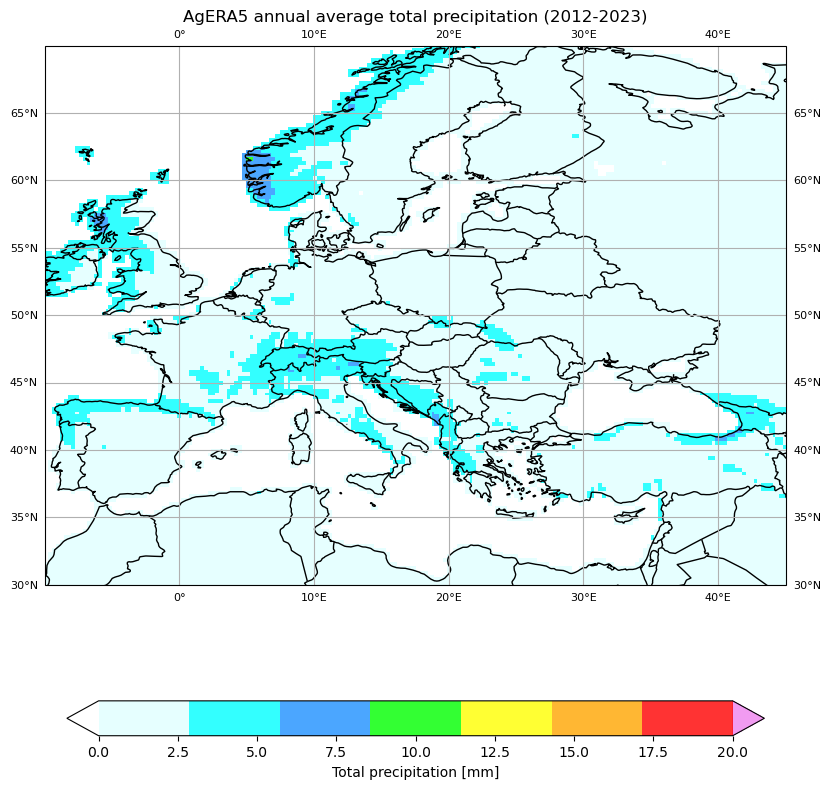

In [37]:
fig = plt.figure(figsize=(18, 10))
ax = plt.subplot(projection=ccrs.PlateCarree())
lons = mean_row_t.lon.values
lats = mean_row_t.lat.values
data = mean_row_t.squeeze()
g1 = ax.gridlines(draw_labels = True)
g1.xlabel_style = {'size': 8, 'color': 'k'}
g1.ylabel_style = {'size': 8, 'color': 'k'}
cmap_prec = mpl.colors.ListedColormap(['lightcyan','cyan','dodgerblue','lime', 'yellow','orange','red']) 
cmap_prec.set_over('violet')
cmap_prec.set_under('white')
im=ax.pcolormesh(lons, lats , data, shading='auto',
              alpha=0.8, cmap=cmap_prec,antialiased=True, linewidth=0.5,vmin= 0, vmax=20)
cbar = fig.colorbar(im, extend='both', shrink=0.5, ax=ax,orientation= 'horizontal')#,ticklocation= 'bottom')
cbar.set_label('Total precipitation [mm]')
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)
#ax.set_xlim([2, 25])
#ax.set_ylim([32.5, 50.])
plt.title('AgERA5 annual average total precipitation (2012-2023)',fontsize= '12')

Text(0.5, 1.0, 'AgERA5_v1_bias-corrected v EOBS_v30 annual average total precipitation (2012-2023)')

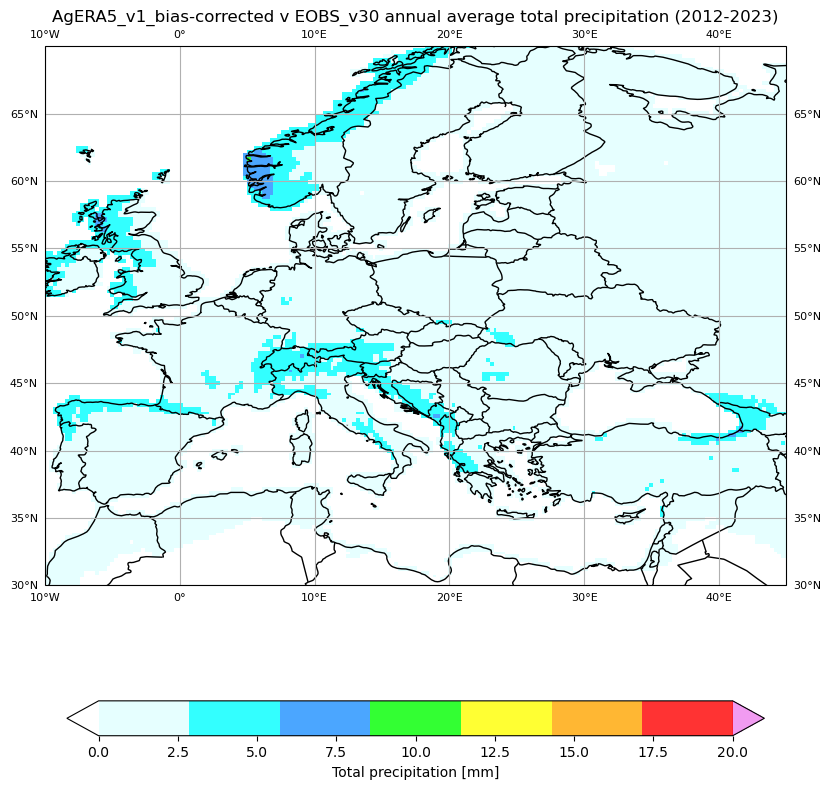

In [38]:
fig = plt.figure(figsize=(18, 10))
ax = plt.subplot(projection=ccrs.PlateCarree())
lons = mean_bias_eobsv30.longitude.values
lats = mean_bias_eobsv30.latitude.values
data = mean_bias_eobsv30.squeeze()
g1 = ax.gridlines(draw_labels = True)
g1.xlabel_style = {'size': 8, 'color': 'k'}
g1.ylabel_style = {'size': 8, 'color': 'k'}
cmap_prec = mpl.colors.ListedColormap(['lightcyan','cyan','dodgerblue','lime', 'yellow','orange','red']) 
cmap_prec.set_over('violet')
cmap_prec.set_under('white')
im=ax.pcolormesh(lons, lats , data, shading='auto',
              alpha=0.8, cmap=cmap_prec,antialiased=True, linewidth=0.5,vmin= 0, vmax=20)
cbar = fig.colorbar(im, extend='both', shrink=0.5, ax=ax,orientation= 'horizontal')#,ticklocation= 'bottom')
cbar.set_label('Total precipitation [mm]')
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)
#ax.set_xlim([2, 25])
#ax.set_ylim([32.5, 50.])
plt.title('AgERA5_v1_bias-corrected v EOBS_v30 annual average total precipitation (2012-2023)',fontsize= '12')

Text(0.5, 1.0, 'AgERA5_v1_bias-corrected v MARS_25 annual average total precipitation (2012-2023)')

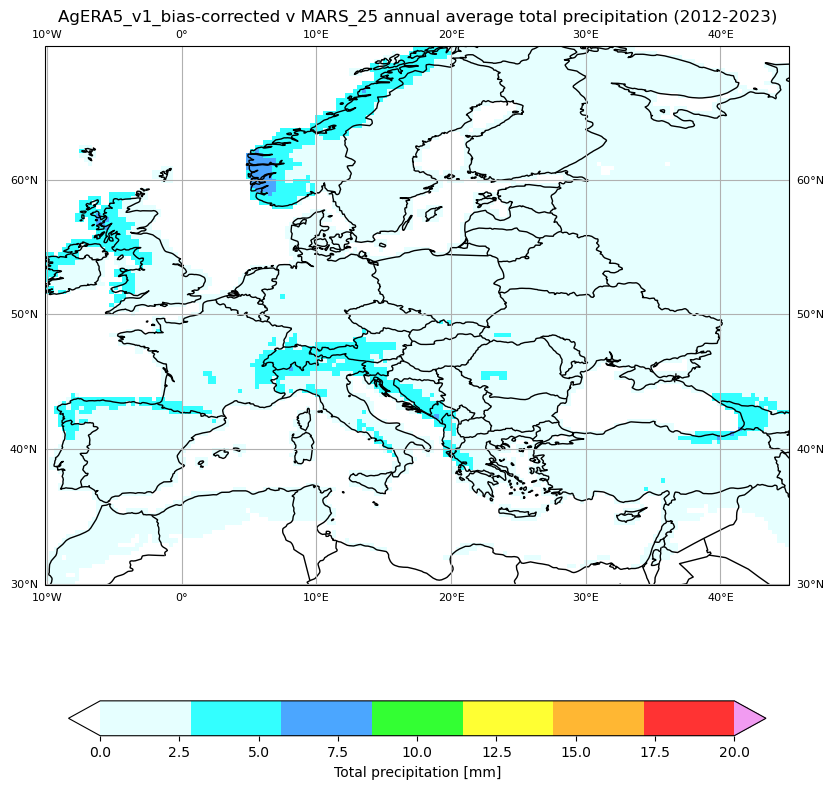

In [39]:
fig = plt.figure(figsize=(18, 10))
ax = plt.subplot(projection=ccrs.PlateCarree())
lons = mean_bias_mars25.longitude.values
lats = mean_bias_mars25.latitude.values
data = mean_bias_mars25.squeeze()
g1 = ax.gridlines(draw_labels = True)
g1.xlabel_style = {'size': 8, 'color': 'k'}
g1.ylabel_style = {'size': 8, 'color': 'k'}
cmap_prec = mpl.colors.ListedColormap(['lightcyan','cyan','dodgerblue','lime', 'yellow','orange','red']) 
cmap_prec.set_over('violet')
cmap_prec.set_under('white')
im=ax.pcolormesh(lons, lats , data, shading='auto',
              alpha=0.8, cmap=cmap_prec,antialiased=True, linewidth=0.5,vmin= 0, vmax=20)
cbar = fig.colorbar(im, extend='both', shrink=0.5, ax=ax,orientation= 'horizontal')#,ticklocation= 'bottom')
cbar.set_label('Total precipitation [mm]')
ax.add_feature(cf.COASTLINE)
ax.add_feature(cf.BORDERS)
#ax.set_xlim([2, 25])
#ax.set_ylim([32.5, 50.])
plt.title('AgERA5_v1_bias-corrected v MARS_25 annual average total precipitation (2012-2023)',fontsize= '12')